In [2]:
# importing libs
%pylab inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import tqdm
from tqdm import tqdm
import sklearn
from sklearn.metrics import *
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


In [3]:
# load validation dataset
df = pd.read_csv('sampleSubmission.csv' , sep =';')

In [4]:
# number of images in each folder
files_val = os.listdir('val') 
number_files_val = len(files_val)

number_cat = len(os.listdir('train/cat'))
number_dog = len(os.listdir('train/dog'))
number_train = number_cat + number_dog

number_cat_test = len(os.listdir('test/cat'))
number_dog_test = len(os.listdir('test/dog'))
number_test = number_cat_test + number_dog_test

In [5]:
# building CNN with Keras
clf = Sequential()
clf.add(Conv2D(64, (3,3), input_shape = (64, 64, 3), activation = 'relu'))
clf.add(BatchNormalization())
clf.add(MaxPooling2D(pool_size = (2,2)))

clf.add(Conv2D(64, (3,3), input_shape = (64, 64, 3), activation = 'relu'))
clf.add(BatchNormalization())
clf.add(MaxPooling2D(pool_size = (2,2)))

clf.add(Flatten())

clf.add(Dense(units = 128, activation = 'relu'))
clf.add(Dropout(0.2))
clf.add(Dense(units = 128, activation = 'relu'))
clf.add(Dropout(0.2))
clf.add(Dense(units = 1, activation = 'sigmoid'))

clf.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                      metrics = ['accuracy'])

In [6]:
gerador_treinamento = ImageDataGenerator(rescale = 1./255,
                                         rotation_range = 7,
                                         horizontal_flip = True,
                                         shear_range = 0.2,
                                         height_shift_range = 0.07,
                                         zoom_range = 0.2)
gerador_teste = ImageDataGenerator(rescale = 1./255)

base_treinamento = gerador_treinamento.flow_from_directory('train',
                                                           target_size = (64, 64),
                                                           batch_size = 32,
                                                           class_mode = 'binary')

base_teste = gerador_teste.flow_from_directory('test',
                                               target_size = (64, 64),
                                               batch_size = 32,
                                               class_mode = 'binary')

Found 25100 images belonging to 2 classes.
Found 1610 images belonging to 2 classes.


In [7]:
clf.fit_generator(base_treinamento, steps_per_epoch = number_train/50,
                            epochs = 100, validation_data = base_teste,
                            validation_steps = number_test )

Epoch 1/100
502/502 [==============================] - 1180s 2s/step - loss: 0.8917 - accuracy: 0.5692 - val_loss: 0.6119 - val_accuracy: 0.6646
Epoch 2/100
502/502 [==============================] - 323s 643ms/step - loss: 0.6163 - accuracy: 0.6544
Epoch 3/100
502/502 [==============================] - 178s 354ms/step - loss: 0.5804 - accuracy: 0.6919
Epoch 4/100
502/502 [==============================] - 155s 308ms/step - loss: 0.5292 - accuracy: 0.7356
Epoch 5/100
502/502 [==============================] - 150s 300ms/step - loss: 0.4899 - accuracy: 0.7672
Epoch 6/100
502/502 [==============================] - 144s 287ms/step - loss: 0.4641 - accuracy: 0.7861
Epoch 7/100
502/502 [==============================] - 142s 283ms/step - loss: 0.4405 - accuracy: 0.7958
Epoch 8/100
502/502 [==============================] - 141s 282ms/step - loss: 0.4235 - accuracy: 0.7988
Epoch 9/100
502/502 [==============================] - 142s 284ms/step - loss: 0.4133 - accuracy: 0.8101
Epoch 10/100
50

In [9]:
# showing the cnn structure
print(clf.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

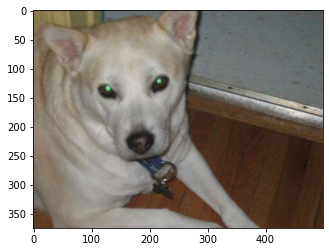

In [10]:
# example of dog image validation
img = mpimg.imread('val/'+files_val[0])
imgplot = plt.imshow(img)
plt.show()

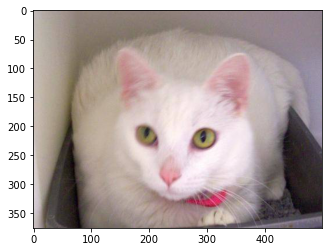

In [11]:
# example of cat image validation
img = mpimg.imread('val/'+files_val[1])
imgplot = plt.imshow(img)
plt.show()

In [13]:
name_img = []
final_predict = []

tqdm.pandas()
for i in tqdm(range(0, number_files_val, 1)):
    file_name = files_val[i][0:files_val[i].find('.')]
    imagem_teste = image.load_img('val/'+files_val[i] ,
                                  target_size = (64,64))
    imagem_teste = image.img_to_array(imagem_teste)
    imagem_teste /= 255
    imagem_teste = np.expand_dims(imagem_teste, axis = 0)
    previsao = clf.predict(imagem_teste)
    final_predict.append(previsao[0][0])
    name_img.append(file_name)

100%|██████████| 160/160 [00:09<00:00, 17.73it/s]


In [14]:
print(base_treinamento.class_indices)

{'cat': 0, 'dog': 1}


In [15]:
final_predict = [ 1 if item > 0.5 else 0 for item in final_predict]

In [16]:
df_val = pd.DataFrame(list(zip(name_img, final_predict)) , columns=['id','predict'])
df_val['id'] = df_val['id'].astype('int')

In [17]:
df_val = df_val.sort_values(by=['id'] , ascending=True)

df_final = pd.merge(df_val, df[['id','label']] ,how ='left', on ='id')

In [18]:
acc = accuracy_score(df_final['label'] ,df_final['predict']) 
print('CNN Accuracy: ',acc*100, '%')

CNN Accuracy:  88.75 %


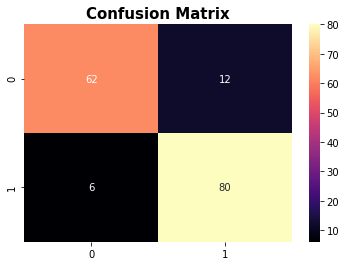

In [19]:
# confusion matrix
cm = confusion_matrix(df_final['label'] ,df_final['predict'] )
sns.heatmap(cm, annot=True , cmap ='magma')
plt.title('Confusion Matrix' , size = 15 , weight = 'bold')
plt.show()